# DGV-PTTOT-S
Modello per previsione time_tot su griglia fissa con sottoinsieme del dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

Creo un sottoinsieme (riproducibile) del dataset DGV-PTTOT di 5K record.

In [2]:
import os.path
from sklearn.model_selection import train_test_split

if not os.path.exists("data/input/DGV_PTTOT_S_train.csv") or not os.path.exists("data/input/DGV_PTTOT_S_TEST.csv"):
    df = pd.concat([pd.read_csv("data/input/DGV_PTTOT_train.csv"), pd.read_csv("data/input/DGV_PTTOT_test.csv")])
    df = df.sample(5000, random_state=42)
    train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
    train_set.to_csv("data/input/DGV_PTTOT_S_train.csv", index=False)
    test_set.to_csv("data/input/DGV_PTTOT_S_test.csv", index=False)

In [3]:
train_df = pd.read_csv("data/input/DGV_PTTOT_S_train.csv")
test_df = pd.read_csv("data/input/DGV_PTTOT_S_test.csv")

Di seguito, verifico che le distribuzione dei vari parametri rispetto al data set originale siano rispettate.

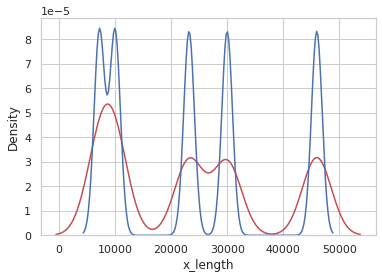

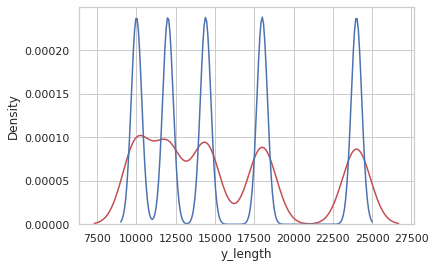

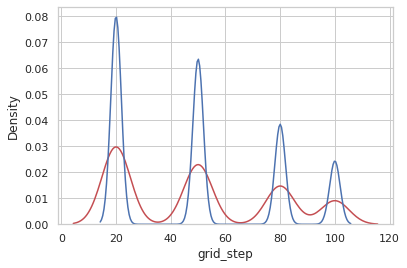

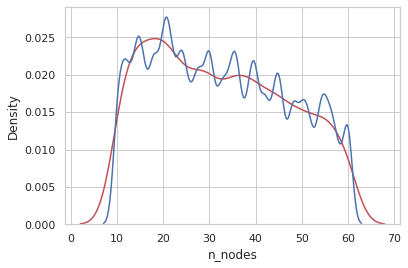

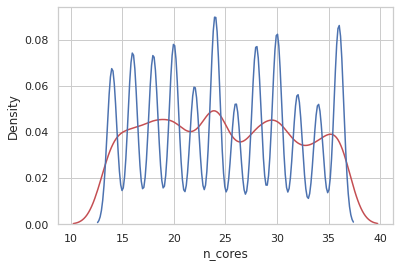

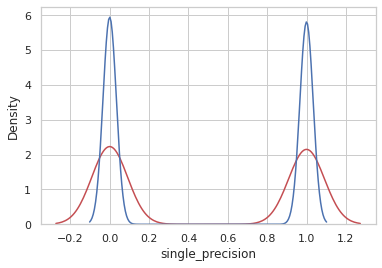

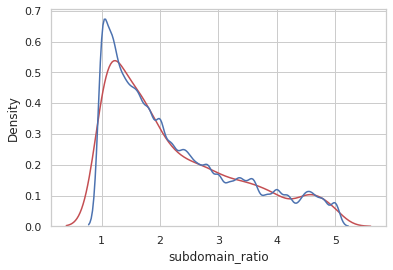

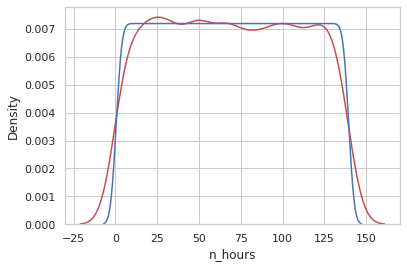

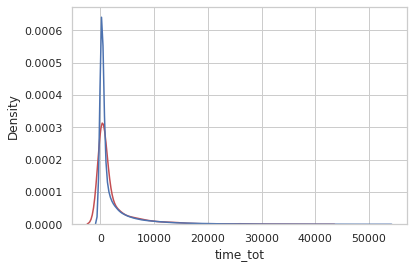

In [4]:
sample_df = pd.concat([pd.read_csv("data/input/DGV_PTTOT_S_train.csv"), pd.read_csv("data/input/DGV_PTTOT_S_test.csv")])
total_df = pd.concat([pd.read_csv("data/input/DGV_PTTOT_train.csv"), pd.read_csv("data/input/DGV_PTTOT_test.csv")])
for k in sample_df.columns:
    sns.kdeplot(sample_df[k], color="r", alpha=0.3)
    sns.kdeplot(total_df[k], color="b", alpha=0.3)
    plt.savefig(f"tex/images/dgv-pttot-s/param-{k}-distribution.pdf")
    plt.show()

## Regressione lineare

In [5]:
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
data = CosmoData(train_df, None, test_df)
reg = reg.fit(data.train_set()[0], data.train_set()[1])

test_res_lr = test_df.copy()
test_res_lr["target"] = test_res_lr.time_tot
test_res_lr["prediction"] = np.exp(reg.predict(data.test_set()[0]))
test_res_lr["residual"] = test_res_lr.target - test_res_lr.prediction
test_res_lr["abs_err"] = (test_res_lr.target - test_res_lr.prediction).abs()
test_res_lr["rel_err"] = test_res_lr.abs_err / test_res_lr.target
test_res_lr[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,894.352911,0.587123
std,1855.228611,1.082691
min,0.312333,0.000761
25%,49.058398,0.197336
50%,166.085018,0.364893
75%,858.667251,0.570413
max,20693.369884,12.831149


In [6]:
print("RMSE:", np.sqrt((test_res_lr.abs_err ** 2).mean()))

RMSE: 2058.7128152821106


Il grafico del tempo previsto e del tempo osservato mostra come la regressione lineare sottostimi i tempi più lunghi e come tale errore aumenti all'aumentare del tempo osservato.

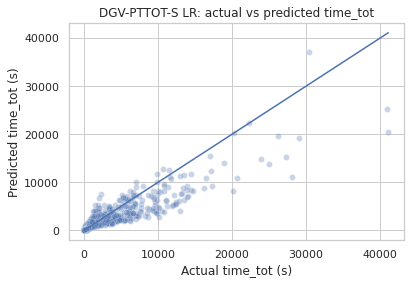

In [7]:
plt.title("DGV-PTTOT-S LR: actual vs predicted time_tot")
plt.plot([0, test_res_lr.target.max()], [0, test_res_lr.target.max()])
sns.scatterplot(data=test_res_lr, x="target", y="prediction", alpha=0.3)
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Predicted time_tot (s)")
plt.savefig("tex/images/dgv-pttot-s/lr-correlazione-osservazione-previsione.pdf")
plt.show()

Possiamo notare la medesima cosa analizzando il grafico dei residui. Inoltre possiamo notare come si presente un pattern che suggerisce non linearità: il grafico del confronto tra previsione e residuo dovrebbe avere un aspetto casuale, proprio perché l'errore della previsione dovrebbe essere casuale.

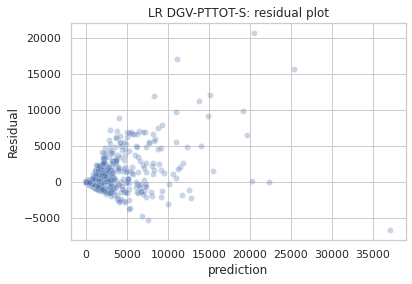

In [8]:
plt.title("LR DGV-PTTOT-S: residual plot")
sns.scatterplot(data=test_res_lr, x="prediction", y="residual", alpha=0.3)
plt.ylabel("Predicted time_tot (s)")
plt.ylabel("Residual")
plt.savefig("tex/images/dgv-pttot-s/lr-grafico-residui.pdf")
plt.show()

## FCNN con HP tuning
Il modello è stato sottoposto a hyperparameter tuning, effettuando 500 tentativi con Bayesian Optimization. Come funzione obiettivo da minimizzare è stato considerato unicamente RMSE, in quanto si è interessati a minimizzare l'errore per le esecuzioni più lunghe e a non avere outlier. Per ogni tentativo, è stato effettuato il 10-fold cross validation ed è stato preso il minimo valore di RMSE del cross-validation set.

In [9]:
with open("data/hpopt/DGV_PTTOT_S.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial

In [10]:
cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
config = best["result"]["config"]

In [11]:
print("Numero di esperimenti per HP tuning:", len(trials))

Numero di esperimenti per HP tuning: 500


In [12]:
print("Best loss", best["result"]["loss"])

Best loss 215.34948886258536


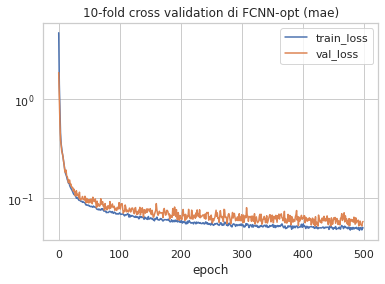

In [13]:
cv_res.groupby("epoch")[["train_loss", "val_loss"]].mean().plot(grid=True, logy=True)
plt.title(f"10-fold cross validation di FCNN-opt ({config['loss']})")
plt.show()

Epoch del minimo della funzione obiettivo, sarà usata successivamente per riaddestrare il modello.

In [14]:
best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
print("Best epoch", best_epoch)

Best epoch 425


Il modello ottimizzato ha tre hidden layer e usa MAE come loss function.

In [15]:
print(yaml.dump(config))

batch: 64
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 42
  - dropout: 0.0
    size: 24
  - dropout: 0.0
    size: 54
optimizer:
  lr: 0.0014092384643065352
  name: adam
  weight_decay: 0.06052921153575907



Il modello viene riaddestrato usando tutto il training set, fino all'epoch che ha dato il miglior risultato durante l'HP tuning.

In [16]:
import os.path
train_res_opt_file = "data/output/DGV_PTTOT_S_train_result.csv"
test_res_opt_file = "data/output/DGV_PTTOT_S_test_result.csv"
if os.path.exists(train_res_opt_file) and os.path.exists(test_res_opt_file):
    print("Carico i risultati del modello da file")
else:
    data = CosmoData(train_df, None, test_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_opt = model.fit(data, best_epoch)
    test_res_opt = model.test(data)
    train_res_opt.to_csv(train_res_opt_file, index=False)
    test_res_opt.to_csv(test_res_opt_file, index=False)
    
train_res_opt = pd.read_csv(train_res_opt_file)
test_res_opt = pd.read_csv(test_res_opt_file)

Carico i risultati del modello da file


<AxesSubplot:>

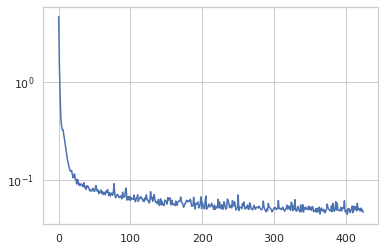

In [17]:
train_res_opt.train_loss.plot(grid=True, logy=True)

Si nota un miglioramento di almeno un ordine di grandezza, sia in termini di errore assoluto che relativo.

In [18]:
test_res_opt["abs_err"] = (test_res_opt.target - test_res_opt.prediction).abs()
test_res_opt["rel_err"] = test_res_opt.abs_err / test_res_opt.target
test_res_opt["residual"] = test_res_opt.target - test_res_opt.prediction
test_res_opt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,137.752160,0.061520
std,335.016884,0.065965
min,0.000648,0.000020
25%,5.900534,0.023166
50%,20.724213,0.045621
75%,96.284534,0.079065
max,3862.613281,0.557411


Il RMSE è ~150 secondi in più rispetto al RMSE del cross-validation set.

In [19]:
print("RMSE:", np.sqrt((test_res_opt.abs_err ** 2).mean()))

RMSE: 362.0769724210947


Possiamo notare il netto miglioramento, soprattutto per i tempi più lunghi.

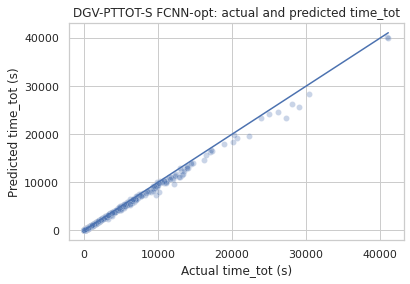

In [20]:
plt.title("DGV-PTTOT-S FCNN-opt: actual and predicted time_tot")
plt.plot([test_res_opt.target.min(), test_res_opt.target.max()], [test_res_opt.target.min(), test_res_opt.target.max()])
sns.scatterplot(x=test_res_opt.target, y=test_res_opt.prediction, alpha=0.3)
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Predicted time_tot (s)")
plt.savefig("tex/images/dgv-pttot-s/fcnn-noopt-correlazione-osservazione-previsione.pdf")
plt.show()

Il modello presenta eteroschedasticità

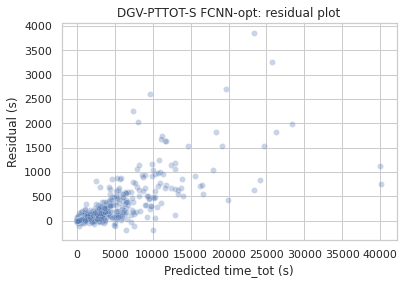

In [21]:
plt.title("DGV-PTTOT-S FCNN-opt: residual plot")
sns.scatterplot(data=test_res_opt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time_tot (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgv-pttot-s/fcnn-noopt-grafico-residui.pdf")
plt.show()

L'errore assoluto è molto più contenuto nel caso di FCNN.

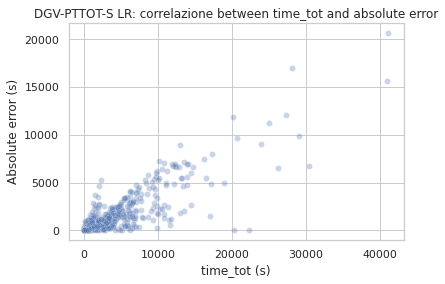

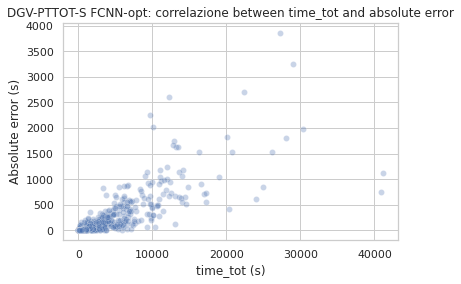

In [22]:
for name, df in (
    ("LR", test_res_lr),
    ("FCNN-opt", test_res_opt),
):
    sns.scatterplot(data=df, x="target", y="abs_err", alpha=0.3)
    plt.title(f"DGV-PTTOT-S {name}: correlazione between time_tot and absolute error")
    plt.xlabel("time_tot (s)")
    plt.ylabel("Absolute error (s)")
    plt.savefig(f"tex/images/dgv-pttot-s/{name}-correlazione-osservazione-errore-assoluto.pdf")
    plt.show()

Qui sotto vediamo invece la correlazione con l'errore relativo: il pattern è il medesimo, ma gli errori relativi di LR sono un ordine di grandezza maggiori. Gli errori relativo più alti si verificano nel caso delle esecuzioni più brevi, come ci si poteva aspettare avendo privilegiato la minimizzazione del RMSE. 

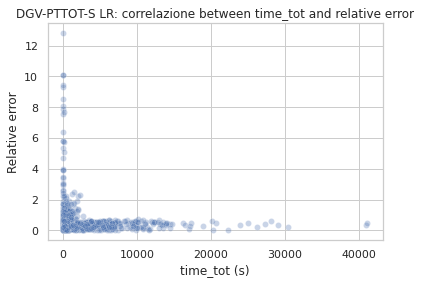

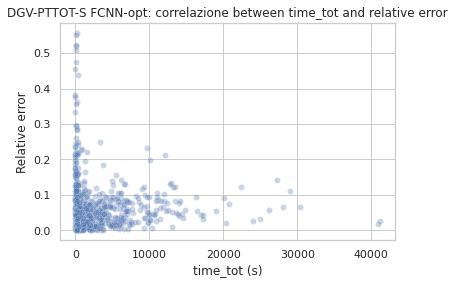

In [23]:
for name, df in (
    ("LR", test_res_lr),
    ("FCNN-opt", test_res_opt),
):
    sns.scatterplot(data=df, x="target", y="rel_err", alpha=0.3)
    plt.title(f"DGV-PTTOT-S {name}: correlazione between time_tot and relative error")
    plt.xlabel("time_tot (s)")
    plt.ylabel("Relative error")
    plt.savefig(f"tex/images/dgv-pttot-s/{name}-correlazione-osservazione-errore-relativo.pdf")
    plt.show()

Di seguito, possiamo vedere le funzioni cumulative dell'errore assoluto e relativo dei due modelli studiati. Come si poteva già dedurre dalle precedenti osservazioni, il modello FCNN è migliore di LR. In particolare, tutte le previsioni hanno un errore relativo minore del 100%.

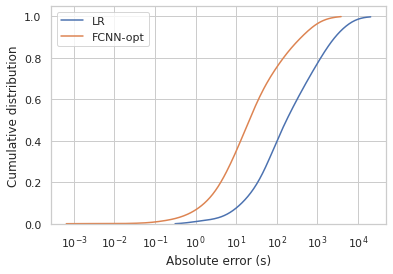

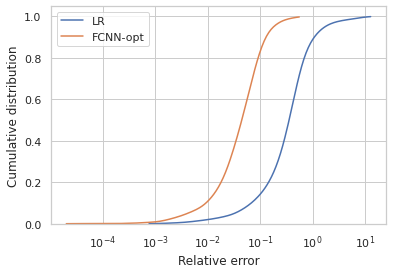

In [24]:
for name, df in (
    ("LR", test_res_lr),
    ("FCNN-opt", test_res_opt),
):
    sns.kdeplot(data=df, x="abs_err", log_scale=True, cumulative=True, cut=0, label=name)
    plt.legend()
    plt.xlabel("Absolute error (s)")
    plt.ylabel("Cumulative distribution")

plt.savefig("tex/images/dgv-pttot-s/cdf-errore-assoluto.pdf")    
plt.show()

for name, df in (
    ("LR", test_res_lr),
    ("FCNN-opt", test_res_opt),
):
    sns.kdeplot(data=df, x="rel_err", log_scale=True, cumulative=True, cut=0, label=name)
    plt.legend()
    plt.xlabel("Relative error")
    plt.ylabel("Cumulative distribution")
    
plt.savefig("tex/images/dgv-pttot-s/cdf-errore-relativo.pdf")    
plt.show()

FCNN è l'unico modello che ha unimodalità in entrambi i casi. Inoltre, dal PDF si nota in modo particolare come l'errore relativo sia contenuto e, facendo riferimento alla correlazione tra questo e il tempo di esecuzione, i valori più alti si verificano nei casi di esecuzioni brevi.

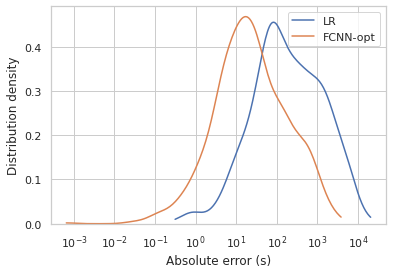

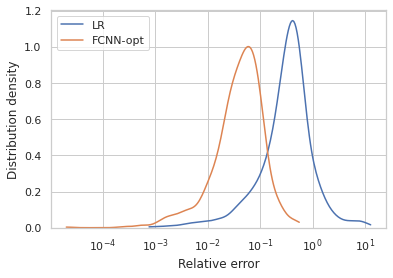

In [25]:
for name, df in (
    ("LR", test_res_lr),
    ("FCNN-opt", test_res_opt),
):
    sns.kdeplot(data=df, x="abs_err", log_scale=True, cumulative=False, cut=0, label=name)
    plt.legend()
    plt.xlabel("Absolute error (s)")
    plt.ylabel("Distribution density")

plt.savefig("tex/images/dgv-pttot-s/pdf-errore-assoluto.pdf")
plt.show()

for name, df in (
    ("LR", test_res_lr),
    ("FCNN-opt", test_res_opt),
):
    sns.kdeplot(data=df, x="rel_err", log_scale=True, cumulative=False, cut=0, label=name)
    plt.legend()
    plt.xlabel("Relative error")
    plt.ylabel("Distribution density")

plt.savefig("tex/images/dgv-pttot-s/pdf-errore-relativo.pdf")
plt.show()

## Conclusioni
FCNN con HP tuning ha prestazioni sensibilmente migliori rispetto a LR. Il modello si comporta in modo soddisfacente: in particolare, le previsioni con un errore relativo maggiore del 10% sono un numero limitato e quasi esclusivamente relative a esecuzioni brevi, mentre per i job con tempi di esecuzione più alti l'errore relativo è quasi sempre minore del 10%.

Percentuali di previsioni con errore relativo > 10%: 15.1


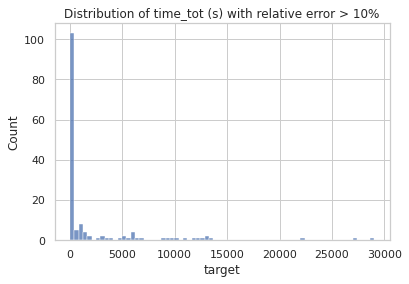

In [26]:
print("Percentuali di previsioni con errore relativo > 10%:", 100*test_res_opt.query("rel_err > 0.1").shape[0] / test_res_opt.shape[0])
sns.histplot(data=test_res_opt.query("rel_err > 0.1"), x="target")
plt.title("Distribution of time_tot (s) with relative error > 10%")
plt.show()

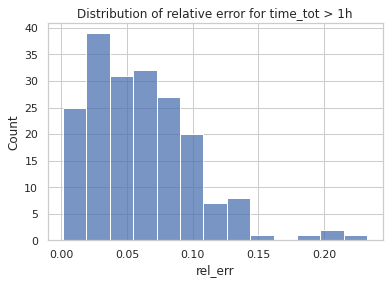

In [27]:
sns.histplot(data=test_res_opt.query("target > 3600"), x="rel_err")
plt.title("Distribution of relative error for time_tot > 1h")
plt.show()

Il modello verrà poi confrontato con DGV-PTTOT sull'intero dataset.